# Imports

In [22]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from scipy import stats
import sklearn
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import PolynomialFeatures
#importing the models
import Kmeans
import ALS
import NN
import Surprize
import pickle as pkl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Find predictors weights

In [2]:
#useful constants
submission_path='submission.csv'
training_path = "data/data_train.csv"
format_path = "data/sampleSubmission.csv"

In [3]:
#Loading the data
print("Loading datasets")
try:
    input_ = pd.read_csv(training_path)
    format_ = pd.read_csv(format_path)
except FileNotFoundError:
    print("Impossible to load training or format files, "
          "please double check")

Loading datasets


In [4]:
#Splitting the data
np.random.seed(1)
train, test =sklearn.model_selection.train_test_split(input_,test_size=0.1)

In [5]:
#computing the predictions of the Surprize algorithm
predictions_surprize_test = Surprize.main(train.copy(), test.copy(), 
                                          cache_name="test")

#computing the predictions of the ALS algorithm
predictions_als_test=ALS.main(train.copy(), test.copy())

#computing the best prediction of the kmeans algorithm
k=6
predictions_kmeans_test = Kmeans.main(train.copy(), test.copy(), k, rounded=False)

#computing the prediction of the NN algorithm
predictions_nn_test = NN.main(train.copy(), test.copy())

Retrieving cached predictions
Ensuring cached IDs match given IDs
Indices match, continuing
##### SVD ####
Already computed SVD, skipping
##### Baseline ####
Already computed Baseline, skipping
##### NMF ####
Already computed NMF, skipping
##### Slope One ####
Already computed Slope One, skipping
##### KNN Basic ####
Already computed KNN Basic, skipping
##### KNN Means ####
Already computed KNN Means, skipping
##### KNN Baseline ####
Already computed KNN Baseline, skipping
##### KNN Zscore ####
Already computed KNN Zscore, skipping
##### SVD ++ ####
Already computed SVD ++, skipping
##### Co Clustering ####
Already computed Co Clustering, skipping
DONE computing surprize
Trying to retrieve cached optimal matrix factorization
Successfully retrieved cached optimal matrix factorization
Emitting predictions 117696/117696
Kmeans for k= 6 :
The current iteration of k-means is: 40, the average loss is 102.1739517117957..


C:\Users\ajlre\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
1059256/1059256 [==============================] - 31s 30us/step - loss: 1.0354
Epoch 2/10
1059256/1059256 [==============================] - 31s 29us/step - loss: 1.0083
Epoch 3/10
1059256/1059256 [==============================] - 32s 30us/step - loss: 1.0011
Epoch 4/10
1059256/1059256 [==============================] - 30s 29us/step - loss: 0.9961
Epoch 5/10
1059256/1059256 [==============================] - 31s 29us/step - loss: 0.9922
Epoch 6/10
1059256/1059256 [==============================] - 31s 29us/step - loss: 0.9896
Epoch 7/10
1059256/1059256 [==============================] - 31s 29us/step - loss: 0.9874
Epoch 8/10
1059256/1059256 [==============================] - 31s 29us/step - loss: 0.9856
Epoch 9/10
1059256/1059256 [==============================] - 30s 28us/step - loss: 0.9842
Epoch 10/10
1059256/1059256 [==============================] - 30s 28us/step - loss: 0.9827
Generating predictions ...


In [6]:
#generating a predictions matrix (each column is the set of predictions of one model)
true_ratings_test = test.copy()
true_ratings_test.set_index("Id", inplace=True)
true_ratings_test.columns = ["y"]
concat_test = pd.concat([predictions_als_test, 
                    predictions_kmeans_test, 
                    predictions_nn_test, 
                    predictions_surprize_test, 
                    true_ratings_test], axis=1, sort=False)
concat_test.head()

## Augmentation

In [8]:
#augmentation function
def augmentation(concat):
    poly = PolynomialFeatures(3)
    X = concat.loc[:,~(concat.columns == "y")]
    print("Augmenting {} columns".format(len(X.columns)))
    if "y" in concat.columns:
        y = concat.loc[:, "y"]
    else:
        y = None
    X = pd.DataFrame(poly.fit_transform(X), columns=poly.get_feature_names(), index=concat.index)
    return X, y

In [9]:
#augmenting the test samples
X_test, y_test = augmentation(concat_test)

Augmenting 13 columns


In [10]:
#cross-validating a ridge model using lambda between 100 and 250
rr = RidgeCV(alphas=np.linspace(100, 250, 60), store_cv_values=True).fit(X_test,y_test)
predictor_coefficients = dict(zip(X_test.columns, rrcoef_))

In [26]:
rr.intercept_

1.1945456804726544

In [25]:
#saving the parameters of the ridge model (hyperparameters of EOM)
with open('ridge_coefs.pkl','wb') as f:
    pkl.dump(rr.coef_,f)

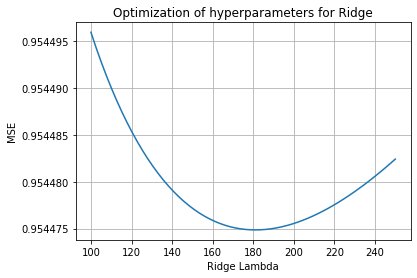

In [11]:
#Plotting the results of the cross-validation
plt.plot(np.linspace(100, 250, 60), rr.cv_values_.mean(axis=0));
plt.xlabel("Ridge Lambda")
plt.ticklabel_format(useOffset=False)
plt.ylabel("MSE")
plt.title("Optimization of hyperparameters for Ridge")
plt.grid()
plt.savefig("figures/crossval_ridge.png")
plt.show()

# Final training and predictions

In [ ]:
#training the models using the full dataset
predictions_surprize_final = Surprize.main(input_.copy(), format_.copy(), 
                                           cache_name="final")

predictions_als_final=ALS.main(input_.copy(), format_.copy(), cache_name="final")

k=6
predictions_kmeans_final = Kmeans.main(input_.copy(), format_.copy(), k, rounded=False)

predictions_nn_final = NN.main(input_.copy(), format_.copy())

In [ ]:
#generating the final predictions using our trained ridge model and the predictions of all our models
concat_final = pd.concat([predictions_als_final, 
                    predictions_kmeans_final, 
                    predictions_nn_final, 
                    predictions_surprize_final], axis=1, sort=False)
concat_aug_final, _ = augmentation(concat_final)
del concat_final
concat_aug_final["Prediction"] = rr.intercept_
for col in concat_aug_final:
    if col != "Prediction":
        concat_aug_final["Prediction"] += concat_aug_final.loc[:, col]*predictor_coefficients[col]
concat_aug_final["Prediction"] = concat_aug_final["Prediction"].apply(lambda x: int(np.clip(np.round(x),1,5)))
concat_aug_final.index.name = "Id"

In [ ]:
#saving our final prediction
concat_aug_final.to_csv(submission_path, columns=["Prediction"])